In [26]:
# https://api.mongodb.com/python/current/tutorial.html
import pprint
from pymongo import MongoClient
import pandas as pd
import requests as req 
import json
import math
import re
import folium
from folium import plugins
import os
from dotenv import load_dotenv
load_dotenv()
import matplotlib.pyplot as plt
import seaborn as sns

api_key = os.environ["key"]   

client = MongoClient('mongodb://localhost:27017/')
db = client.ejercicio

In [3]:
# {$and:[{deadpooled_year:null}, {number_of_employees:{$ne:null}}, {"offices.latitude":{$ne:null}}, {"offices.latitude":{$exists:true}}]}

In [4]:
empresas= db.companhias.find({"$and":[{"deadpooled_year":None}, {"number_of_employees":{"$ne":None}},{"total_money_raised":{"$ne":None}}, {"offices.latitude":{"$ne":None}}, {"offices.latitude":{"$exists":"true"}}]})

In [5]:
df=pd.DataFrame(empresas)[["name","category_code","number_of_employees","founded_year", "total_money_raised","offices"]]

In [6]:
df.head()

,name,category_code,number_of_employees,founded_year,total_money_raised,offices
0,Digg,news,60,2004.0,$45M,"[{'description': None, 'address1': '135 Missis..."
1,Geni,web,18,2006.0,$16.5M,"[{'description': 'Headquarters', 'address1': '..."
2,Fox Interactive Media,web,0,1979.0,$0,"[{'description': '', 'address1': '407 N Maple ..."
3,Scribd,news,50,2007.0,$25.8M,"[{'description': 'HQ', 'address1': '539 Bryant..."
4,MeetMoi,social,15,2007.0,$5.58M,"[{'description': None, 'address1': '', 'addres..."


In [7]:
df1=df.copy()

In [8]:
res = req.get("https://api.exchangeratesapi.io/latest?base=USD").json()

In [9]:
def cambiar(string):
    if string.startswith("$"):
        string=string.replace("$","")
        if string.endswith("M"):
            string=string.replace("M","")
            string= float(string)*1000000
        elif string.endswith("k"):
            string=string.replace("k","")
            string= float(string)*1000
        elif string.endswith("B"):
            string=string.replace("B","")
            string= float(string)*1000000000
        else:
            string=float(string)
    
    elif string.startswith("€"):
        string=string.replace("€","")
        if string.endswith("M"):
            string=string.replace("M","")
            string= (float(string)*1000000)/res["rates"]["EUR"]
        elif string.endswith("k"):
            string=string.replace("k","")
            string= (float(string)*1000)/res["rates"]["EUR"]
        elif string.endswith("B"):
            string=string.replace("B","")
            string= (float(string)*1000000000)/res["rates"]["EUR"]
        else:
            string=float(string)
            
    elif string.startswith("£"):
        string=string.replace("£","")
        if string.endswith("M"):
            string=string.replace("M","")
            string= (float(string)*1000000)/res["rates"]["GBP"]
        elif string.endswith("k"):
            string=string.replace("k","")
            string= (float(string)*1000)/res["rates"]["GBP"]
        elif string.endswith("B"):
            string=string.replace("B","")
            string= (float(string)*1000000000)/res["rates"]["GBP"]
        else:
            string=float(string)

    elif string.startswith("¥"):
        string=string.replace("¥","")
        if string.endswith("M"):
            string=string.replace("M","")
            string= (float(string)*1000000)/res["rates"]["JPY"]
        elif string.endswith("k"):
            string=string.replace("k","")
            string= (float(string)*1000)/res["rates"]["JPY"]
        elif string.endswith("B"):
            string=string.replace("B","")
            string= (float(string)*1000000000)/res["rates"]["JPY"]
        else:
            string=float(string)
      
    elif string.startswith("C$"):
        string=string.replace("C$","")
        if string.endswith("M"):
            string=string.replace("M","")
            string= (float(string)*1000000)/res["rates"]["CAD"]
        elif string.endswith("k"):
            string=string.replace("k","")
            string= (float(string)*1000)/res["rates"]["CAD"]
        elif string.endswith("B"):
            string=string.replace("B","")
            string= (float(string)*1000000000)/res["rates"]["CAD"]
        else:
            string=float(string)
            
    elif string.startswith("kr"):
        string=string.replace("kr","")
        if string.endswith("M"):
            string=string.replace("M","")
            string= (float(string)*1000000)/res["rates"]["SEK"]
        elif string.endswith("k"):
            string=string.replace("k","")
            string= (float(string)*1000)/res["rates"]["SEK"]
        elif string.endswith("B"):
            string=string.replace("B","")
            string= (float(string)*1000000000)/res["rates"]["SEK"]
        else:
            string=float(string)
        
    return string

In [10]:
lst=[]
for a in range(len(df1)):
    lst.append(df1["offices"][a][0]["city"])
df1["ciudad"]=lst

In [11]:
df1["total_money_raised"]=df1["total_money_raised"].apply(cambiar)

In [12]:
df1.head()

,name,category_code,number_of_employees,founded_year,total_money_raised,offices,ciudad
0,Digg,news,60,2004.0,45000000.0,"[{'description': None, 'address1': '135 Missis...",San Francisco
1,Geni,web,18,2006.0,16500000.0,"[{'description': 'Headquarters', 'address1': '...",West Hollywood
2,Fox Interactive Media,web,0,1979.0,0.0,"[{'description': '', 'address1': '407 N Maple ...",Beverly Hills
3,Scribd,news,50,2007.0,25800000.0,"[{'description': 'HQ', 'address1': '539 Bryant...",San Francisco
4,MeetMoi,social,15,2007.0,5580000.0,"[{'description': None, 'address1': '', 'addres...",New York City


In [13]:
def getFirst(data):
    data = data['offices']
#    return (len(data),data[0]['latitude'],data[0]['longitude'])

    # Only create the geoJSON object if all geodata is available
    principal = None
    if data[0]['latitude'] and data[0]['longitude']:
        principal = {
            "type":"Point",
            "coordinates":[data[0]['longitude'], data[0]['latitude']]
        }

    return {
        "totalOffices": len(data),
        "lat": data[0]['latitude'],
        "lng": data[0]['longitude'],
        "oficina_principal": principal
    }


first_office = df1[["offices"]].apply(getFirst, result_type="expand", axis=1)

In [14]:
first_office.head()

,lat,lng,oficina_principal,totalOffices
0,37.764726,-122.394523,"{'type': 'Point', 'coordinates': [-122.394523,...",1
1,34.090368,-118.393064,"{'type': 'Point', 'coordinates': [-118.393064,...",1
2,34.076179,-118.394170,"{'type': 'Point', 'coordinates': [-118.39417, ...",1
3,37.789634,-122.404052,"{'type': 'Point', 'coordinates': [-122.404052,...",1
4,40.757929,-73.985506,"{'type': 'Point', 'coordinates': [-73.985506, ...",1


In [15]:
df_clean = pd.concat([df1,first_office], axis=1)[["name","lng","lat", "oficina_principal","totalOffices", "category_code", "number_of_employees", "founded_year", "total_money_raised", "ciudad"]]

In [17]:
df_clean.to_json('limpio.json', orient="records")

In [18]:
df_clean.to_csv('limpio.csv')

In [19]:
oficinas=df_clean.copy()

In [35]:
oficinas=oficinas[(oficinas["total_money_raised"]>1000000) & (oficinas["founded_year"]>2005)]
lista_paises=list(oficinas.ciudad.value_counts().head(20).index)

df20=oficinas[oficinas["ciudad"].isin(lista_paises)]
df20

(288, 10)

In [36]:
df20.to_json('mirar.json', orient="records")

In [22]:
def calcMedia(c):
    bd = oficinas[oficinas["ciudad"]==c]
    contador=bd.ciudad.count()
    suma=bd.total_money_raised.sum()
    media=round(suma/contador)
    return media
res=[]
for c in lista_paises:
    a=calcMedia(c)
    res.append(a)
print(res)

[41958871.0, 17979663.0, 7014211.0, 6239012.0, 38832833.0, 23011429.0, 24362138.0, 20353333.0, 13466667.0, 22922222.0, 4385714.0, 36412528.0, 24351667.0, 7950000.0, 11989170.0, 29200000.0, 17002062.0, 12850000.0, 13570000.0, 4812500.0]


In [23]:
ciudad_media=pd.DataFrame()
ciudad_media["ciudad"]=lista_paises
ciudad_media["media"]=res

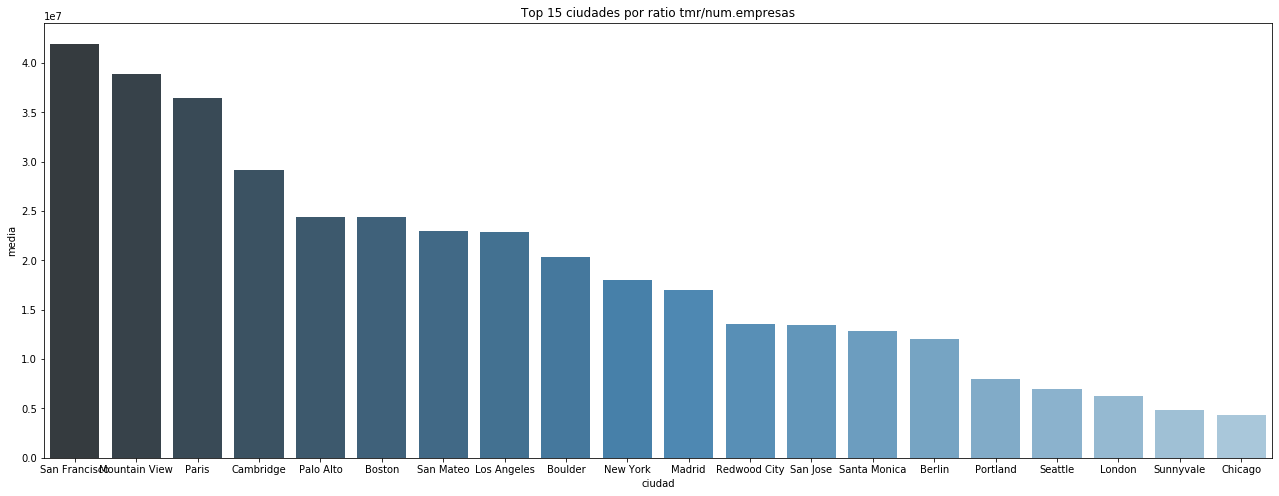

In [30]:
ciudad_media=ciudad_media.sort_values(["media"], ascending=False)
plt.subplots(figsize=(22,8))
sns.barplot(ciudad_media["ciudad"],ciudad_media["media"],palette='Blues_d')
plt.title('Top 15 ciudades por ratio tmr/num.empresas')
plt.savefig('paises.png')

In [75]:
ciudas=ciudad_media.ciudad[0]

lonlat= req.get("https://api.opencagedata.com/geocode/v1/json?q={}&key={}".format(ciudas, api_key)).json()
lonlat
llat=lonlat["results"][0]["geometry"]["lat"]
llng=lonlat["results"][0]["geometry"]["lng"]
print(llat,llng)



37.7790262 -122.4199061


In [39]:
df20.head()

,name,lng,lat,oficina_principal,totalOffices,category_code,number_of_employees,founded_year,total_money_raised,ciudad
3,Scribd,-122.404052,37.789634,"{'type': 'Point', 'coordinates': [-122.404052,...",1,news,50,2007.0,2.580000e+07,San Francisco
5,Joost,-74.009447,40.746497,"{'type': 'Point', 'coordinates': [-74.0094471,...",1,games_video,0,2006.0,4.500000e+07,New York
6,Twitter,-122.416924,37.776805,"{'type': 'Point', 'coordinates': [-122.4169244...",1,social,1300,2006.0,1.160000e+09,San Francisco
10,Powerset,-122.395289,37.778613,"{'type': 'Point', 'coordinates': [-122.395289,...",1,search,60,2006.0,2.250000e+07,San Francisco
13,Kyte,-122.409173,37.788482,"{'type': 'Point', 'coordinates': [-122.409173,...",1,games_video,40,2006.0,2.340000e+07,San Francisco


In [65]:
m = folium.Map([37, -72], zoom_start=2)
stationArr = df20[['lat', 'lng']].values
m.add_child(plugins.HeatMap(stationArr, radius=15))
m

In [77]:
df20.head()

,name,lng,lat,oficina_principal,totalOffices,category_code,number_of_employees,founded_year,total_money_raised,ciudad
3,Scribd,-122.404052,37.789634,"{'type': 'Point', 'coordinates': [-122.404052,...",1,news,50,2007.0,2.580000e+07,San Francisco
5,Joost,-74.009447,40.746497,"{'type': 'Point', 'coordinates': [-74.0094471,...",1,games_video,0,2006.0,4.500000e+07,New York
6,Twitter,-122.416924,37.776805,"{'type': 'Point', 'coordinates': [-122.4169244...",1,social,1300,2006.0,1.160000e+09,San Francisco
10,Powerset,-122.395289,37.778613,"{'type': 'Point', 'coordinates': [-122.395289,...",1,search,60,2006.0,2.250000e+07,San Francisco
13,Kyte,-122.409173,37.788482,"{'type': 'Point', 'coordinates': [-122.409173,...",1,games_video,40,2006.0,2.340000e+07,San Francisco


In [100]:
#https://docs.mongodb.com/manual/reference/operator/query/near/index.html
def findNear(coor):
    query=db.limpio.find({"oficina_principal": {"$near": {"$geometry": {"type":"Point","coordinates":coor},"$maxDistance": 1000,}}})
    num = query.count()
    coord=query[0]["oficina_principal"]["coordinates"]
    name=query[0]["name"]
    print(num)
    return name,num,coord

In [90]:

#def eligeCoordenadas():
bd = df20[df20["ciudad"]=="Madrid"]

for c in range(len(bd)):
    coor=bd["oficina_principal"].values[c]['coordinates']
    



In [136]:
def find(ciu):
    bd = df20[df20["ciudad"]==ciu]
    cd=[]
    for c in range(len(bd)):
        d={}
        coor=bd["oficina_principal"].values[c]['coordinates']
        query=db.limpio.find({"oficina_principal": {"$near": {"$geometry": {"type":"Point","coordinates":coor},"$maxDistance": 50,}}})
        num = query.count()
        coord=query[0]["oficina_principal"]["coordinates"]
        name=query[0]["name"]
        d.update(numero = num, donde = coord, nombre = name)
        cd.append(d)
    return cd    
    

In [137]:
find("San Francisco")

/usr/local/Cellar/ipython/7.3.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  


[{'numero': 2, 'donde': [-122.404052, 37.789634], 'nombre': 'Scribd'},
 {'numero': 1, 'donde': [-122.4169244, 37.7768052], 'nombre': 'Twitter'},
 {'numero': 1, 'donde': [-122.395289, 37.778613], 'nombre': 'Powerset'},
 {'numero': 1, 'donde': [-122.409173, 37.788482], 'nombre': 'Kyte'},
 {'numero': 1, 'donde': [-122.393913, 37.780716], 'nombre': 'CastTV'},
 {'numero': 1, 'donde': [-122.414689, 37.758113], 'nombre': 'Pageflakes'},
 {'numero': 2, 'donde': [-122.39071, 37.779507], 'nombre': 'Eventbrite'},
 {'numero': 9, 'donde': [-122.419204, 37.775196], 'nombre': 'Seesmic'},
 {'numero': 9, 'donde': [-122.419204, 37.775196], 'nombre': 'Seesmic'},
 {'numero': 1, 'donde': [-122.392142, 37.782263], 'nombre': 'GoingOn'},
 {'numero': 2, 'donde': [-122.406676, 37.766909], 'nombre': 'Flixster'},
 {'numero': 9, 'donde': [-122.419204, 37.775196], 'nombre': 'Seesmic'},
 {'numero': 1, 'donde': [-74.761403, 40.270666], 'nombre': 'Scrybe'},
 {'numero': 2, 'donde': [-122.401245, 37.786942], 'nombre': 'K